# Visualize Scene

In [1]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# define train and test data directories
data_dir = 'images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')
valid_dir = os.path.join(data_dir, 'val/')

classes=['coast', 'forest', 'highway', 'insidecity', 'mountain', 
         'opencountry', 'street', 'tallbuilding']

In [4]:
# load and transform data using ImageFolder

# Resize image as VGG-16 Takes 224x224 images as input
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)


In [5]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                            num_workers=num_workers, drop_last=True,
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                            num_workers=num_workers, drop_last=True)

valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                            num_workers=num_workers)

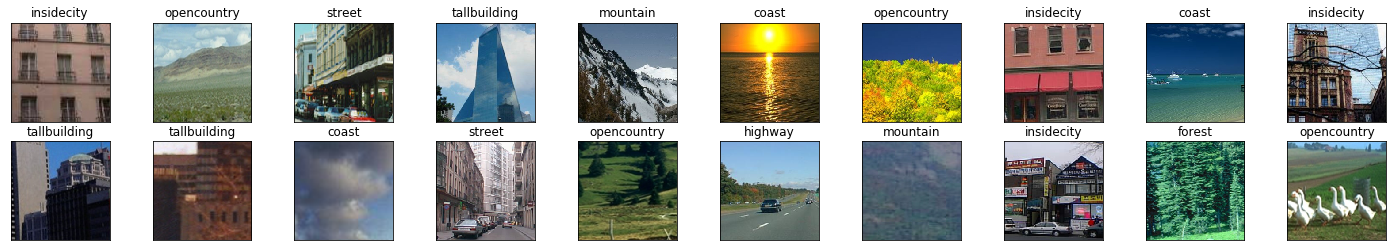

In [6]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [7]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [8]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False
    

# Final Layer

In [9]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
print(vgg16)

8
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv

In [10]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [11]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss


for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    vgg16.train()
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

    # Validate the Model
    vgg16.eval()
    for data, target in valid_loader:
        # Move tensor to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(vgg16.state_dict(), 'vgg16_scene.pt')
        valid_loss_min = valid_loss

Epoch 1, Batch 20 loss: 1.9622388839721681
Epoch 1, Batch 40 loss: 1.7390921592712403
Epoch 1, Batch 60 loss: 1.5457070887088775
Epoch 1, Batch 80 loss: 1.3860929429531097
Epoch 1, Batch 100 loss: 1.2913624286651610
Epoch: 1 	Training Loss: 0.004402 	Validation Loss: 1.136134
Validation loss decreased (inf --> 1.136134).  Saving model ...
Epoch 2, Batch 20 loss: 1.1458821237087249
Epoch 2, Batch 40 loss: 1.0056270509958267
Epoch 2, Batch 60 loss: 1.0215703278779984
Epoch 2, Batch 80 loss: 0.9279311060905456
Epoch 2, Batch 100 loss: 0.8759891986846924
Epoch: 2 	Training Loss: 0.003189 	Validation Loss: 0.773095
Validation loss decreased (1.136134 --> 0.773095).  Saving model ...
Epoch 3, Batch 20 loss: 0.8428483814001083
Epoch 3, Batch 40 loss: 0.7698833584785462
Epoch 3, Batch 60 loss: 0.7542809277772904
Epoch 3, Batch 80 loss: 0.7607900619506835
Epoch 3, Batch 100 loss: 0.6633464649319649
Epoch: 3 	Training Loss: 0.002606 	Validation Loss: 0.631891
Validation loss decreased (0.773095 

Epoch 27, Batch 20 loss: 0.3892235100269318
Epoch 27, Batch 40 loss: 0.3345579504966736
Epoch 27, Batch 60 loss: 0.3545093402266503
Epoch 27, Batch 80 loss: 0.3340204570442438
Epoch 27, Batch 100 loss: 0.3150847047567368
Epoch: 27 	Training Loss: 0.001818 	Validation Loss: 0.361023
Epoch 28, Batch 20 loss: 0.3243908300995827
Epoch 28, Batch 40 loss: 0.3517944708466530
Epoch 28, Batch 60 loss: 0.3939364440739155
Epoch 28, Batch 80 loss: 0.3167413964867592
Epoch 28, Batch 100 loss: 0.3584838822484017
Epoch: 28 	Training Loss: 0.001304 	Validation Loss: 0.333504
Epoch 29, Batch 20 loss: 0.3271549560129642
Epoch 29, Batch 40 loss: 0.3044840432703495
Epoch 29, Batch 60 loss: 0.2703797891736031
Epoch 29, Batch 80 loss: 0.3225783742964268
Epoch 29, Batch 100 loss: 0.3600410729646683
Epoch: 29 	Training Loss: 0.001288 	Validation Loss: 0.368963
Epoch 30, Batch 20 loss: 0.3188650481402874
Epoch 30, Batch 40 loss: 0.4058373812586069
Epoch 30, Batch 60 loss: 0.3491550955921411
Epoch 30, Batch 80 

In [20]:
# track test loss over all classes
test_loss = 0.0
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(8):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.286723

Test Accuracy of coast: 94% (32/34)
Test Accuracy of forest: 90% (28/31)
Test Accuracy of highway: 72% (18/25)
Test Accuracy of insidecity: 96% (28/29)
Test Accuracy of mountain: 83% (30/36)
Test Accuracy of opencountry: 87% (34/39)
Test Accuracy of street: 92% (26/28)
Test Accuracy of tallbuilding: 94% (17/18)

Test Accuracy (Overall): 88% (213/240)


## Save the trained model

In [ ]:
torch.save(vgg16, 'vgg16_scene_full.pt')


## Load the Saved Model

In [ ]:
# vgg16 = torch.load('vgg16_scene.pt')

In [ ]:
# import color map
from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

from sklearn.manifold import TSNE

In [ ]:
OFFSET = 5
def low_dimm_visualization(low_dimm_weights, labels):
    figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
    # clear current axis
    plt.cla()
    X, Y = low_dimm_weights[:, 0], low_dimm_weights[:, 1]
    colors = []
    for label in labels:
        c = cm.rainbow(int(255 * label / 8))
        colors.append(c)
    
    # Plot scatter graph
    plt.scatter(X, Y, c=colors, label=colors)
    plt.xlim(X.min() - OFFSET, X.max() + OFFSET)
    plt.ylim(Y.min() - OFFSET, Y.max() + OFFSET)
    plt.title('Low Dimmension Visualization')
    
    # Legends
    class_colors = []
    for i in range(8):
        class_colors.append(cm.rainbow(int(255 * i / 9)))

    rects = []
    for i in range(len(class_colors)):
        rects.append(mpatches.Rectangle((0,0), 1, 1, fc=class_colors[i]))
    
    # ncol: number of columns
    plt.legend(rects, classes, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [ ]:
# import color map
from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

from sklearn.manifold import TSNE

## Visualize data

The last 4 layers of the VGG16 classifier is removed to create a feature extractor with a length of 4096. The dimmensions are then reduced to 2D.

In [ ]:
vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children())[:3])
print(vgg16)

In [ ]:
low_dim_embs_list = []
labels_list = []
feature_vector_list = []
target_list = []
data_list = []
for step, (data, target) in enumerate(test_loader):
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    
    output = vgg16(data)
    last_layer = output.cpu().detach().numpy()
    labels = target.cpu().detach().numpy()

    for i in range(20):
        feature_vector_list.append(last_layer[i])
        labels_list.append(labels[i])
        data_list.append(data[i])

        
tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(feature_vector_list)
    

low_dim_embs_list = np.array(low_dim_embs)
labels_list = np.array(labels_list)
low_dimm_visualization(low_dim_embs_list, labels_list)


## Visualize Images

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(20, 50))
idx = 1
for d in data_list:
    ax = fig.add_subplot(24, 10, idx, xticks=[], yticks=[])
    plt.imshow(np.transpose(d.cpu().numpy(), (1, 2, 0)))
    ax.set_title(classes[labels_list[idx-1]])
    idx += 1
    
    

## Plot images on a graph

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def get_image(im_path, zoom=0.08):
    return OffsetImage(im_path, zoom=zoom)

x, y = low_dim_embs_list[:, 0], low_dim_embs_list[:, 1]


fig, ax = plt.subplots(figsize=(20, 15))
ax.scatter(x, y) 

for x0, y0, d in zip(x, y,data_list):
    d = d.cpu().numpy()
    im = np.transpose(d, (1, 2, 0))

    ab = AnnotationBbox(get_image(im), (x0, y0), frameon=False)
    ax.add_artist(ab)

## Outliers Rejection
A density-based clustering algorithm, HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) is used to detect outliers. 

In order to detect outliers, HDBSCAN is performed individually on each class scene.

In [ ]:
import hdbscan
import numpy as np
import pandas as pd
print(len(labels_list))
print(len(low_dim_embs_list))


In [ ]:
# Seperate each class scene
print(len(low_dim_embs_list))
low_dim_embs_dict = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: []
}

for i in range(len(low_dim_embs_list)):
    low_dim_embs_dict[labels_list[i]].append(low_dim_embs_list[i].tolist())    

for i in range(len(low_dim_embs_dict)):
    y = np.array(low_dim_embs_dict[i])
    
    cluster = hdbscan.HDBSCAN(min_cluster_size=2)
    cluster.fit(y)
    threshold = pd.Series(cluster.outlier_scores_).quantile(0.9)
    outliers = np.where(cluster.outlier_scores_ > threshold)[0]
    points = np.where(cluster.outlier_scores_ < threshold)[0]
    # Simple display
    y0 = y[points]
    X, Y = y0[:, 0], y0[:, 1]
    c = cm.rainbow(int(255 * i / 8))
    plt.scatter(X, Y, s=50, linewidth=0, c=c, alpha=0.85)
    
#     y1 = y[outliers]
#     X1, Y1 = y1[:, 0], y1[:, 1]
#     plt.scatter(X1, Y1, s=50, linewidth=0, c='black', alpha=0.9)

low_dimm_visualization(low_dim_embs_list, labels_list)



## Replace Scatter points with Actual Images

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def get_image(im_path, zoom=0.1):
    return OffsetImage(im_path, zoom=zoom)

fig, ax = plt.subplots(figsize=(20, 15))
for i in range(len(low_dim_embs_dict)):
    y = np.array(low_dim_embs_dict[i])
    
    cluster = hdbscan.HDBSCAN(min_cluster_size=2)
    cluster.fit(y)
    threshold = pd.Series(cluster.outlier_scores_).quantile(0.9)
    outliers = np.where(cluster.outlier_scores_ > threshold)[0]
    points = np.where(cluster.outlier_scores_ < threshold)[0]
    # Simple display
    y0 = y[points]
    X, Y = y0[:, 0], y0[:, 1]
    ax.scatter(X, Y)

    
x, y = low_dim_embs_list[:, 0], low_dim_embs_list[:, 1]


# fig, ax = plt.subplots(figsize=(20, 15))
# ax.scatter(x, y) 

for x0, y0, d in zip(x, y,data_list):
    d = d.cpu().numpy()
    im = np.transpose(d, (1, 2, 0))

    ab = AnnotationBbox(get_image(im), (x0, y0), frameon=False)
    ax.add_artist(ab)    
